In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib
import os
import sys
import numpy as np
import cmocean.cm as ocm
from scipy.interpolate import griddata
import cartopy.crs as ccrs
import string
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import gsw

proj_dir = os.path.join(os.pardir,os.pardir)
data_dir = os.path.join(proj_dir,'data','analysis')
fig_dir  = os.path.join(proj_dir,'reports','devel','figures')
int_dir = os.path.join(data_dir,'interim')

src_dir = os.path.join(proj_dir,'src')
sys.path.append(src_dir)

from visualization.shiftedColorMap import shiftedColorMap
from roms_tools.cartesian_grid_2d import cartesian_grid_2d

tools_dir = os.path.join(proj_dir,'src','tools')
sys.path.append(tools_dir)
from rotate_vector_roms import rotate_vector_roms
from log_progress import log_progress
from calc_z import calc_z

/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [38]:
temp_path = os.path.join(data_dir,'raw','waom2','ocean_avg_0538-0610_temp_avg.nc')
salt_path = os.path.join(data_dir,'raw','waom2','ocean_avg_0538-0610_salt_avg.nc')
v_path = os.path.join(data_dir,'raw','waom2','ocean_avg_0538-0610_v_avg.nc')
zeta_path = os.path.join(data_dir,'raw','waom2','ocean_avg_0538-0610_zeta_avg.nc')

temp = xr.open_dataset(temp_path).temp.squeeze()
salt = xr.open_dataset(salt_path).salt.squeeze()
v = xr.open_dataset(v_path).v.squeeze()
zeta = xr.open_dataset(zeta_path).zeta.squeeze()

grd_path = os.path.join(data_dir,'interim','grd2_dV.nc')
grd = xr.open_dataset(grd_path)

In [80]:
def make_3D_depth(grd):

    h = grd.h.values
    zice = grd.zice.values
    theta_s = 7
    theta_b = 8
    hc = 250
    N = 31
    Vstretching = 4    
    zeta = zeta.values
        
    depths,s,C = calc_z(h,zice,theta_s,theta_b,hc,N,zeta,Vstretching)
        
    depth_3d =    xr.DataArray(depths,dims=['s_rho','eta_rho','xi_rho']) 
    #ds = ds.assign_coords(depth = xr.DataArray(depths,dims=['ocean_time','s_rho','eta_rho','xi_rho']))
    
    return depth_3d
depths = calc_depths(grd)
temp = temp.assign_coords(depth = xr.DataArray(depths,dims=['s_rho','eta_rho','xi_rho']))
salt = salt.assign_coords(depth = xr.DataArray(depths,dims=['s_rho','eta_rho','xi_rho']))

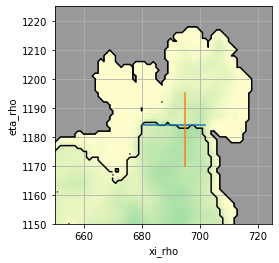

In [78]:
xi,eta = (slice(130*5,145*5),slice(230*5,245*5))

fig,ax = plt.subplots()

ax.contourf(grd.mask_rho.values,colors=(('0.6','0.6','0.6')))
(grd.h+grd.zice).where(grd.mask_rho).plot(ax=ax,cmap=ocm.deep,add_colorbar=False)
ax.contour(-grd.zice.where(grd.mask_rho).values, levels=['0.01'], colors=('black'))
ax.contour(grd.mask_rho.values, levels=['0.01'], colors=('black')) 
ax.set_aspect('equal')
#ax.axis('off')
ax.grid()

ax.plot((680,702),(1184,1184))
ax.plot((695,695),(1170,1195))

xlim = (xi.start,xi.stop)
ylim = (eta.start,eta.stop)
ax.set_xlim(xlim)
ax.set_ylim(ylim)

plt.show()

In [180]:
def make_region(ax):
    ax.contourf(grd.mask_rho.values,colors=(('0.6','0.6','0.6')))
    (grd.h+grd.zice).where(grd.mask_rho).plot(ax=ax,cmap=ocm.deep,add_colorbar=False)
    ax.contour(-grd.zice.where(grd.mask_rho).values, levels=['0.01'], colors=('black'))
    ax.contour(grd.mask_rho.values, levels=['0.01'], colors=('black')) 
    ax.set_aspect('equal')
    #ax.axis('off')
    ax.grid()

    ax.plot((680,702),(1184,1184),'r')
    ax.plot((695,695),(1170,1195),'r')

    ax.set_xlim((660,720))
    ax.set_ylim((1160,1220))
    return ax

In [181]:
xi,eta = (slice(678,703),1184)
sel_rho = {'xi_rho':xi,'eta_rho':eta}
sel_v = {'xi_v':xi,'eta_v':eta}

xi,eta = (695,slice(1170,1195))
sel_rho_in = {'xi_rho':695,'eta_rho':slice(1170,1195)}

In [184]:
def get_freezing_diff(sel):
    temp_sel = temp.sel(sel)
    salt_sel = salt.sel(sel)
    grd_sel = grd.sel(sel)

    p = gsw.p_from_z(grd_sel.z,grd_sel.lat_rho)
    SA = gsw.SA_from_SP(salt_sel,p,grd_sel.lon_rho,grd_sel.lat_rho)
    CT = gsw.CT_from_pt(SA,temp_sel)
    t = gsw.t_from_CT(SA,CT,p)
    t_freezing = gsw.t_freezing(SA,p,np.zeros_like(p))

    return t-t_freezing

temp_diff_in = temp.sel(sel_rho_in).copy()
temp_diff_in.values = get_freezing_diff(sel_rho_in)

temp_diff = temp.sel(sel_rho).copy()
temp_diff.values = get_freezing_diff(sel_rho)

In [185]:
v_trans = v.sel(sel_v).assign_coords(depth = xr.DataArray(temp.sel(sel_rho).depth.values,dims=['s_rho','xi_v']))


<>:9: DeprecationWarning: invalid escape sequence \c
<>:15: DeprecationWarning: invalid escape sequence \c
<>:9: DeprecationWarning: invalid escape sequence \c
<>:15: DeprecationWarning: invalid escape sequence \c
<>:9: DeprecationWarning: invalid escape sequence \c
<>:15: DeprecationWarning: invalid escape sequence \c
<ipython-input-186-d4bc69a1e306>:9: DeprecationWarning: invalid escape sequence \c
  'label':'Temperature difference to freezing [$^{\circ}$C]'})
<ipython-input-186-d4bc69a1e306>:15: DeprecationWarning: invalid escape sequence \c
  'label':'Temperature difference to freezing [$^{\circ}$C]'})


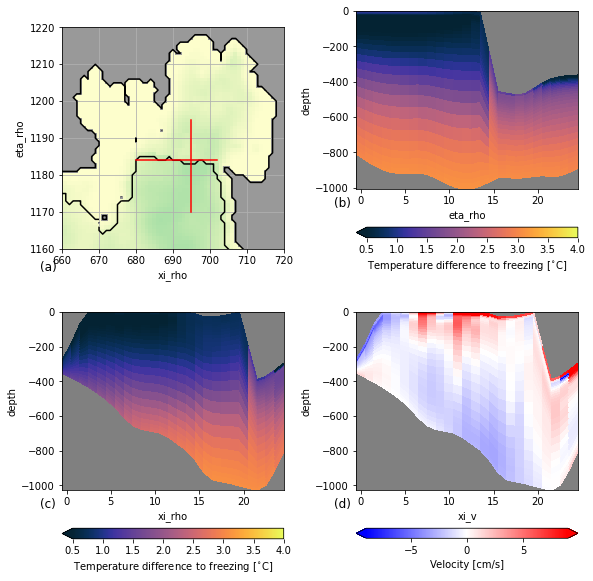

In [186]:
plt.rcParams['axes.facecolor']='gray'
fig,axes = plt.subplots(2,2,figsize=(8.27,8.27))
ax1,ax2,ax3,ax4 = axes.flatten()

ax1 = make_region(ax1)

temp_diff_in.plot(x='eta_rho',y='depth',ax=ax2,cmap=ocm.thermal,vmin=0.5,vmax=4,
                               cbar_kwargs={'orientation': 'horizontal',
                                            'label':'Temperature difference to freezing [$^{\circ}$C]'})

#salt.sel(sel_rho_in).plot.contour(ax=ax2)

temp_diff.plot(x='xi_rho',y='depth',ax=ax3,cmap=ocm.thermal,vmin=0.5,vmax=4,
                               cbar_kwargs={'orientation': 'horizontal',
                                            'label':'Temperature difference to freezing [$^{\circ}$C]'})
(v_trans*-100).plot(x='xi_v',y='depth',ax=ax4,vmin=-9,vmax=9,cmap='bwr',
                               cbar_kwargs={'orientation': 'horizontal',
                                            'label':'Velocity [cm/s]'})
    
n=0
for ax in axes.flatten(): 
    ax.set_title("")
    ax.text(-0.1, -0.1, "("+string.ascii_lowercase[n]+")", transform=ax.transAxes, 
            size=12)
    n+=1   


plt.tight_layout()
out_path = os.path.join(fig_dir,'PIG_CDW_front.png')
fig.savefig(out_path,format='png',dpi=300,bbox_inches = "tight")

plt.show()

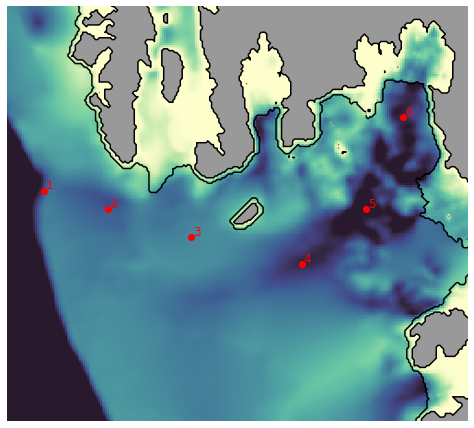

In [187]:
def make_dot(x,y,nb,ax):
    x,y = (x*5,y*5)
    ax.plot(x,y,'ro')
    ax.text(x+1,y+1,nb,color='r',size=12)
    #print(f'{nb}: {x}, {y}')
    return ax    

xi,eta = (slice(95*5,145*5),slice(200*5,245*5))

fig,ax = plt.subplots(figsize=(8.25,8.25))

def make_region(ax):
    ax.contourf(grd.mask_rho.values,colors=(('0.6','0.6','0.6')))
    (grd.h+grd.zice).where(grd.mask_rho).plot(ax=ax,cmap=ocm.deep,vmax=1000,add_colorbar=False)
    ax.contour(-grd.zice.where(grd.mask_rho).values, levels=['0.01'], colors=('black'))
    ax.contour(grd.mask_rho.values, levels=['0.01'], colors=('black')) 
    ax.set_aspect('equal')
    ax.axis('off')

    #ax.grid(which='both')
    #ax.grid(which='minor', alpha=0.5)
    #ax.grid(which='major', alpha=0.5)

    ax = make_dot(99,225,1,ax)
    ax = make_dot(106,223,2,ax)
    ax = make_dot(115,220,3,ax)
    ax = make_dot(127,217,4,ax)
    ax = make_dot(134,223,5,ax)
    ax = make_dot(138,233,6,ax)


    xlim = (xi.start,xi.stop)
    ylim = (eta.start,eta.stop)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    return ax

ax = make_region(ax)

plt.show()

In [188]:
dots = {'1':(495, 1125),'2':(530, 1115),'3':(575, 1100),'4':(635, 1085),'5':(670, 1115),'6':(690, 1165)}

<>:10: DeprecationWarning: invalid escape sequence \c
<>:10: DeprecationWarning: invalid escape sequence \c
<>:10: DeprecationWarning: invalid escape sequence \c
<ipython-input-189-863f8f384f65>:10: DeprecationWarning: invalid escape sequence \c
  ax2.set_xlabel('Temperature difference to freezing [$^{\circ}$C]')


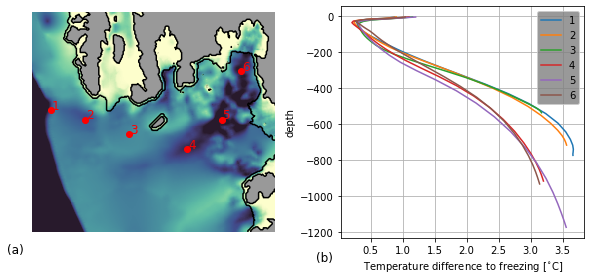

In [189]:
fig,axes = plt.subplots(ncols=2,figsize=(8.27,4))
ax1,ax2 = axes.flatten()

ax1=make_region(ax1)

for key,xy in dots.items():
    temp_diff = temp[:,xy[1],xy[0]].copy()
    temp_diff.values = get_freezing_diff({'xi_rho':xy[0],'eta_rho':xy[1]})
    temp_diff.plot(y='depth',label=key,ax=ax2)
ax2.set_xlabel('Temperature difference to freezing [$^{\circ}$C]')
ax2.set_facecolor('white')
ax2.grid()
ax2.legend()

n=0
for ax in axes.flatten(): 
    ax.set_title("")
    ax.text(-0.1, -0.1, "("+string.ascii_lowercase[n]+")", transform=ax.transAxes, 
            size=12)
    n+=1   

plt.tight_layout()


out_path = os.path.join(fig_dir,'PIG_CDW_shelf.png')
fig.savefig(out_path,format='png',dpi=300,bbox_inches = "tight")

plt.show()

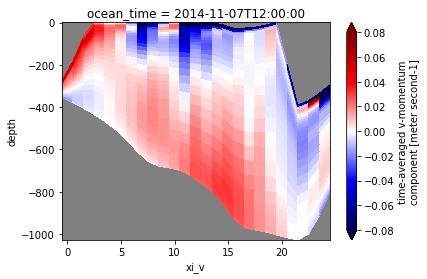

In [75]:
v_trans.plot(x='xi_v',y='depth',vmin=-0.08,vmax=0.08,cmap='seismic')